# **Final Project for DSS Causal Inference for Business Decisions: Understanding Cause and Effect**

## *Mulatua Hasiholan* - Batch Sparta

### Libraries

In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import causaldata 
from causalgraphicalmodels import CausalGraphicalModel
import warnings
warnings.simplefilter("ignore", FutureWarning)

### Observational Data

Data observasional adalah jenis data yang dikumpulkan tanpa adanya intervensi atau perlakuan yang diatur oleh peneliti. Dalam data observasional, peneliti hanya mengamati variabel yang ada dan mencatat kejadian atau fenomena yang terjadi secara alami. Biasanya data obsevasional mudah dikumpulkan dan tersedia. Namun, karena data observasional tidak ada unsur randomisasi, maka akan ada banyak faktor-faktor dari variable lain akan mempengaruhi kesimpulannya. 

### Project Context

Data Source: https://www.kaggle.com/datasets/hwwang98/software-usage-promotion-campaign-uplift-model

A startup that sells software would like to know whether its multiple outreach efforts were successful in attracting new customers or boosting consumption among existing customers. They would also like to distinguish the effects of several incentives on different kinds of customers. In other words, `they would like to learn the heterogeneous treatment effect of each investment on customers' software usage`.

In an ideal world, the startup would run several randomized experiments where each customer would receive a random assortment of investments. However, this can be logistically prohibitive or strategically unsound: the startup might not have the resources to design such experiments or they might not want to risk losing out on big opportunities due to lack of incentives.

### Load Data

In [123]:
software_usage = pd.read_csv('Data/multi_attribution_sample.csv')
software_usage.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


Variables name definitions:
- `Global Flag`     - whether the customer has global offices
- `Major Flag`      - whether the customer is a large consumer in their industry
- `SMC Flag`        - whether the customer is a Small Medium Corporation
- `Commercial Flag` - whether the customer's business is commercial (as opposed to public sector)
- `IT Spend`        - $ spent on IT-related purchases
- `Employee Count`  - number of employees
- `Size`            - customer's size given by their yearly total revenue
- `Tech Support`    - whether the customer received tech support (binary, 1 get tech support)
- `Discount`        - whether the customer was given a discount (binary, 1 get discount)
- `Revenue`         - $ Revenue from customer given by the amount of software purchased

### Hipothesis & Causal Diagram

- Confounders: Customer features.
- Treatment: Incentive was given to a customer.
- Outcome: The amount of product the customer bought in the year after the incentives were given.

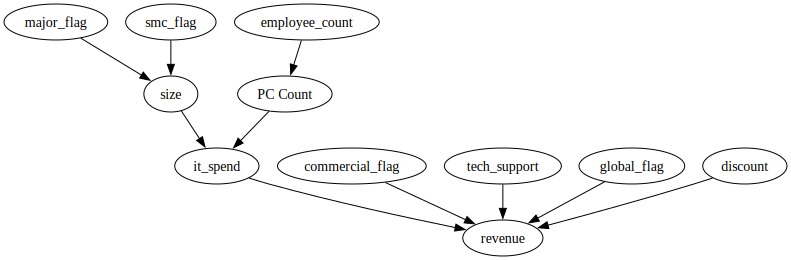

In [124]:
software_usage_dag = CausalGraphicalModel(nodes = ["global_flag", "major_flag", "commercial_flag", "smc_flag","it_spend", "employee_count", "PC Count","size", "tech_support", "discount", "revenue"],
                                       edges = [("global_flag", "revenue"),
                                                ("major_flag", "size"),
                                                ("smc_flag", "size"),
                                                ("commercial_flag", "revenue"),
                                                ("it_spend", "revenue"),
                                                ("employee_count", "PC Count"),
                                                ("PC Count", "it_spend"),
                                                ("size", "it_spend"),
                                                ("discount", "revenue"),
                                                ("tech_support", "revenue"),
                                                ]
                                        )

software_usage_dag.draw()

### Exploratory Data Analysis

*Treatment #1: Discount, Treatment #2 (Tech Support) dianggap tidak ada/diabaikan*

Nama variabel diganti untuk mempermudah saat membuat model lalu dilanjutkan dengan pengecekan kelengkapan data set untuk setiap variabel.

In [125]:
# Merapikan nama variabel
software_usage = software_usage.rename(columns={'Global Flag':'global_flag', 'Major Flag' : 'major', 'SMC Flag':'smc', 'Commercial Flag':'commercial', 'IT Spend':'it_spend', 'Employee Count':'employee', 'PC Count':'pc_count', 'Tech Support':'tech_support'})

In [126]:
# Mengecek kelengkapan data di masing-masing variabel
software_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   global_flag   2000 non-null   int64  
 1   major         2000 non-null   int64  
 2   smc           2000 non-null   int64  
 3   commercial    2000 non-null   int64  
 4   it_spend      2000 non-null   int64  
 5   employee      2000 non-null   int64  
 6   pc_count      2000 non-null   int64  
 7   Size          2000 non-null   int64  
 8   tech_support  2000 non-null   int64  
 9   Discount      2000 non-null   int64  
 10  Revenue       2000 non-null   float64
dtypes: float64(1), int64(10)
memory usage: 172.0 KB


Keseluruhan dataset lengkap untuk setiap varibel. Eksplorasi kemudian dilanjutkan untuk mengetahui komposisi dari variabel treatment dan variabel outcome. Pada project ini, variabel treatmentnya adalah `Discount` dan `Tech Support` sementara variabel outcomenya adalah `Revenue`.

In [127]:
software_usage['Discount'].value_counts()

Discount
1    1021
0     979
Name: count, dtype: int64

In [128]:
software_usage['tech_support'].value_counts()

tech_support
1    1006
0     994
Name: count, dtype: int64

In [129]:
discount_effect_mean = software_usage.groupby('Discount').agg({'Revenue': 'mean'}).applymap(lambda x: f"${x:.2f}")
discount_effect_mean

,Revenue
Discount,
0,$10605.73
1,$19992.98


In [130]:
software_usage.groupby('tech_support').agg({'Revenue': 'mean'}).applymap(lambda x: f"${x:.2f}")

,Revenue
tech_support,
0,$9302.99
1,$21420.14


In [131]:
#ETA Discount
19992.98-10605.73

9387.25

In [132]:
#ETA Tech Support
21420.14-9302.99

12117.15

Dari eksplorasi di atas dapat diambil kesimpulan bahwa klien yang diberikan treatment baik Discount maupun Tech Support melakukan spending lebih banyak dibandingkan klien yang tidak mendapatkan treatment. Namun ada perbedaan efek yang diberikan oleh Discount dan Tech Support dimana:
- Perusahaan klien yang diberikan `Discount` memiliki spending `$ 9387` lebih besar dibandingkan dengan yang tidak mendapatkan treatment.
- Perusahaan klien yang diberikan `Tech Support` memiliki spending `$ 12117` lebih besar dibandingkan dengan yang tidak mendapatkan treatment.

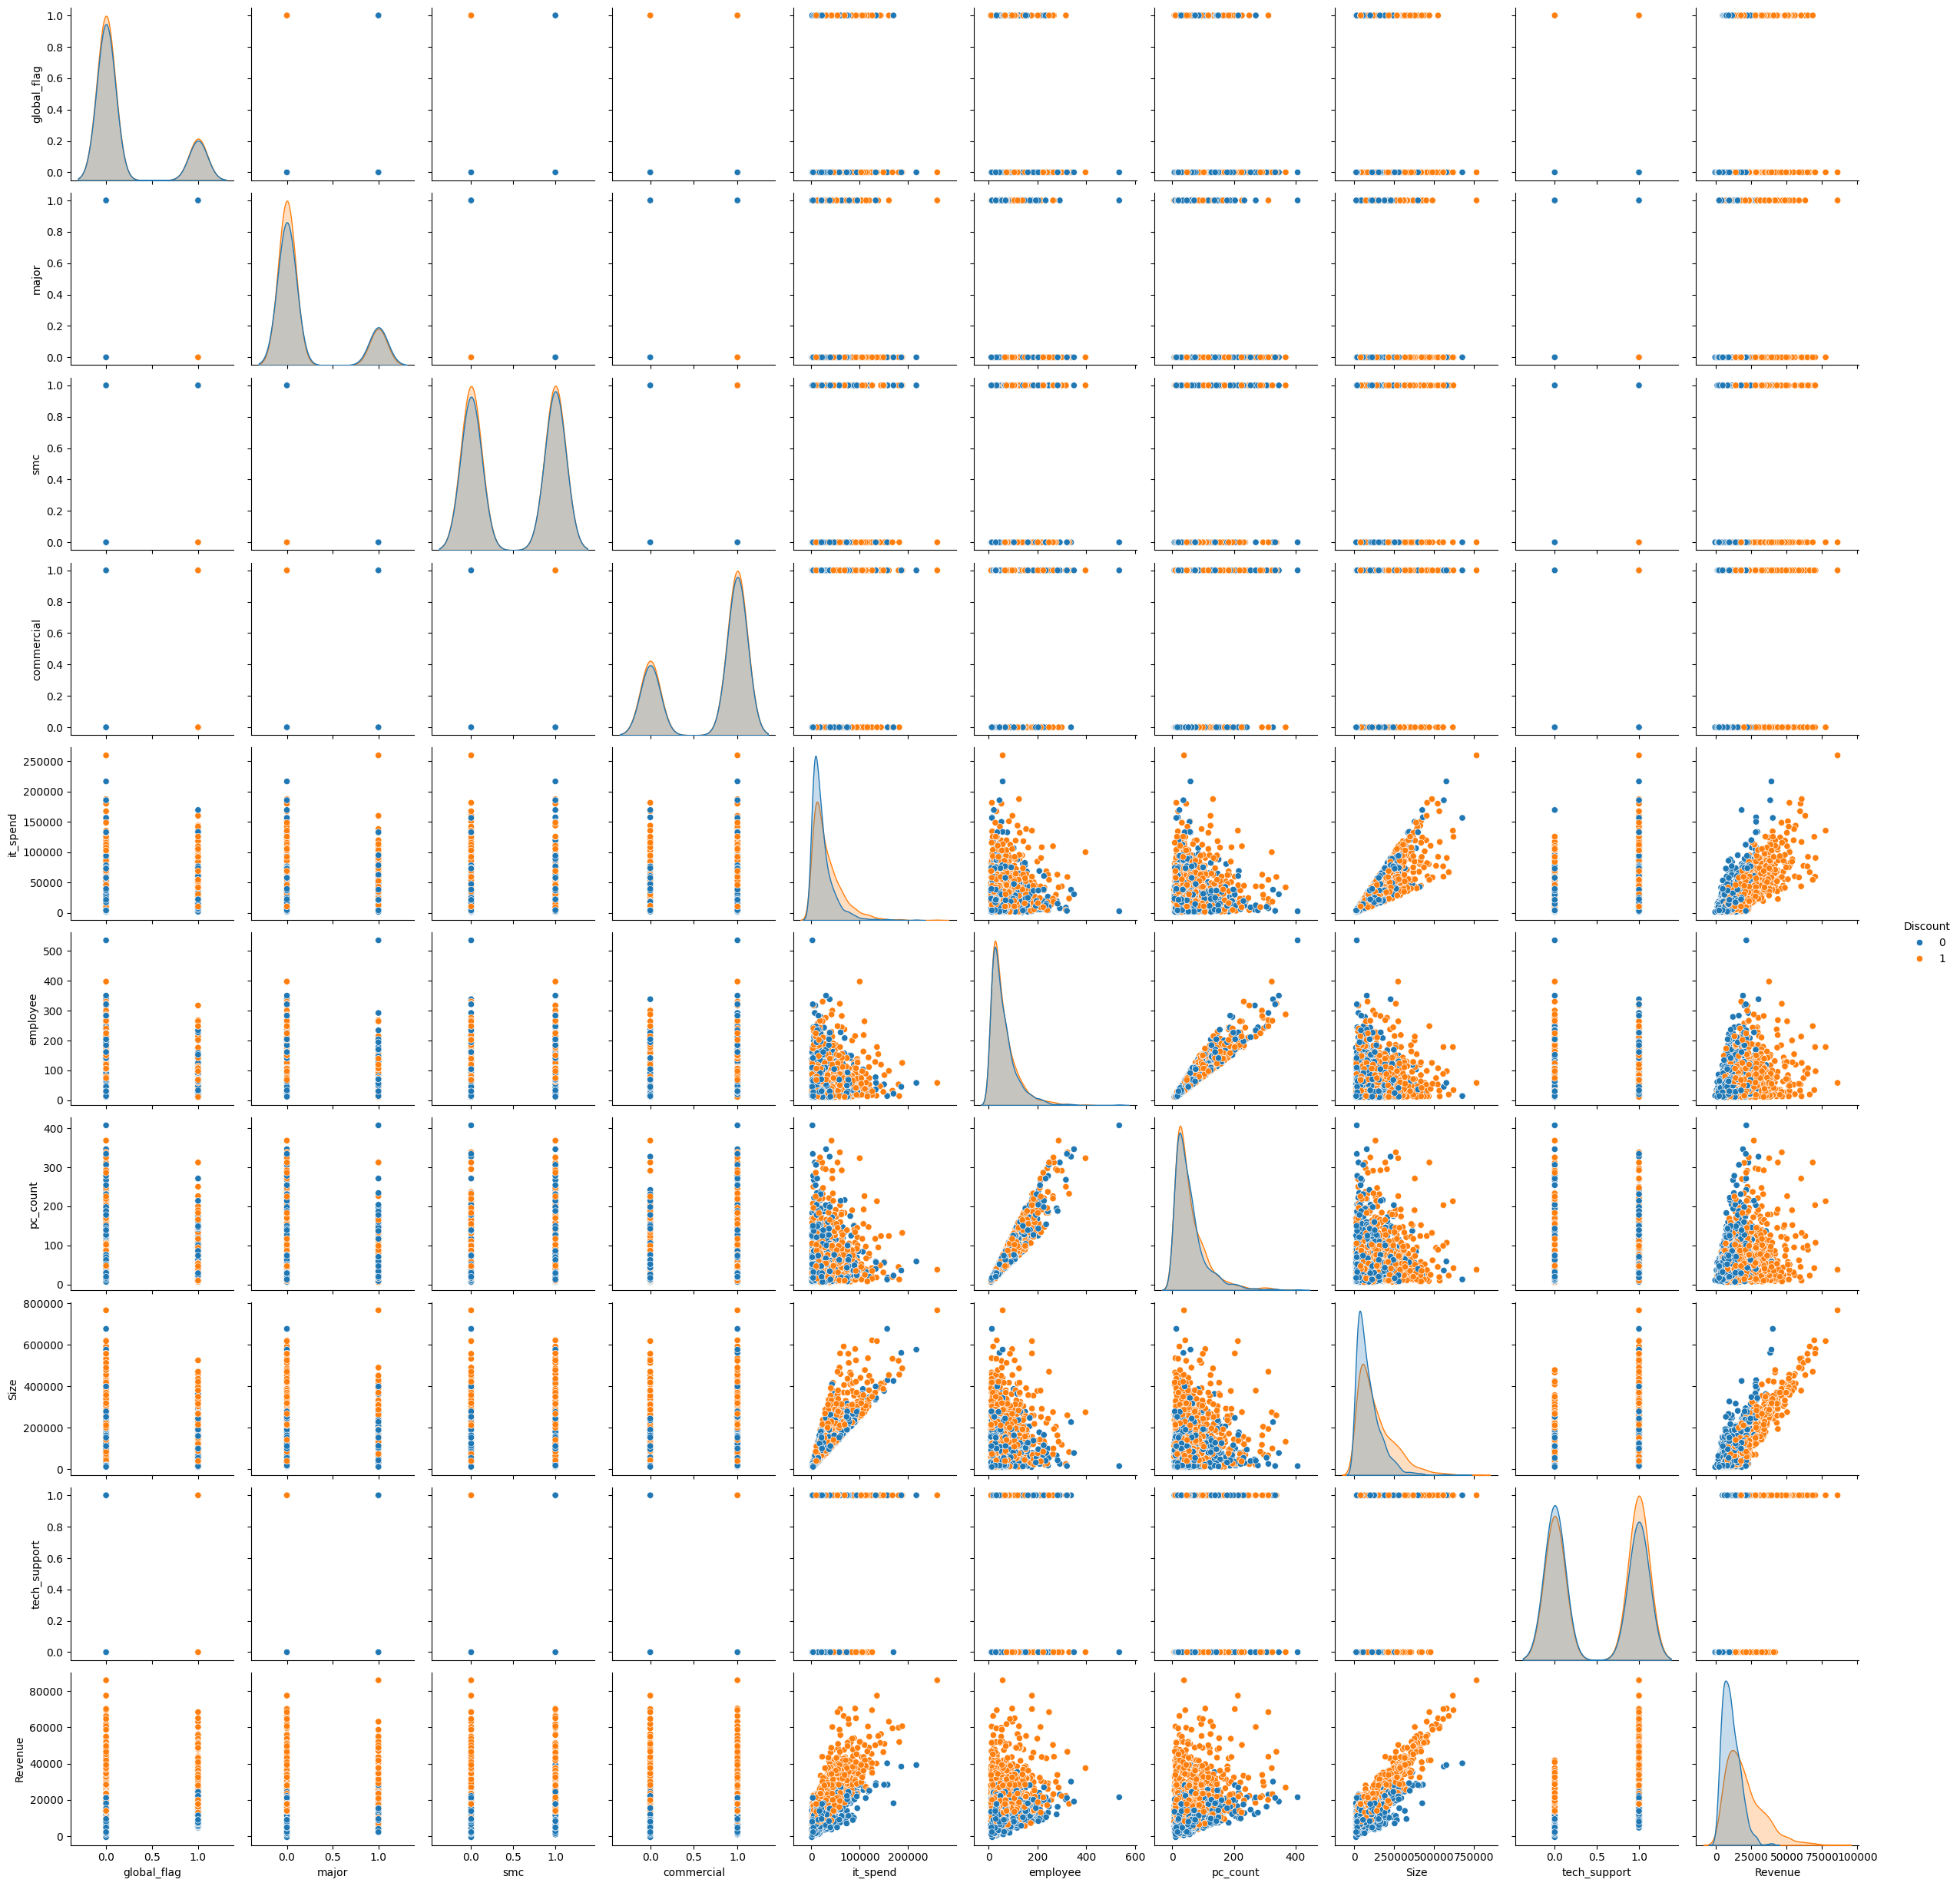

In [133]:
# visualisasi distribusi data
sns.pairplot(data=software_usage, hue='Discount')

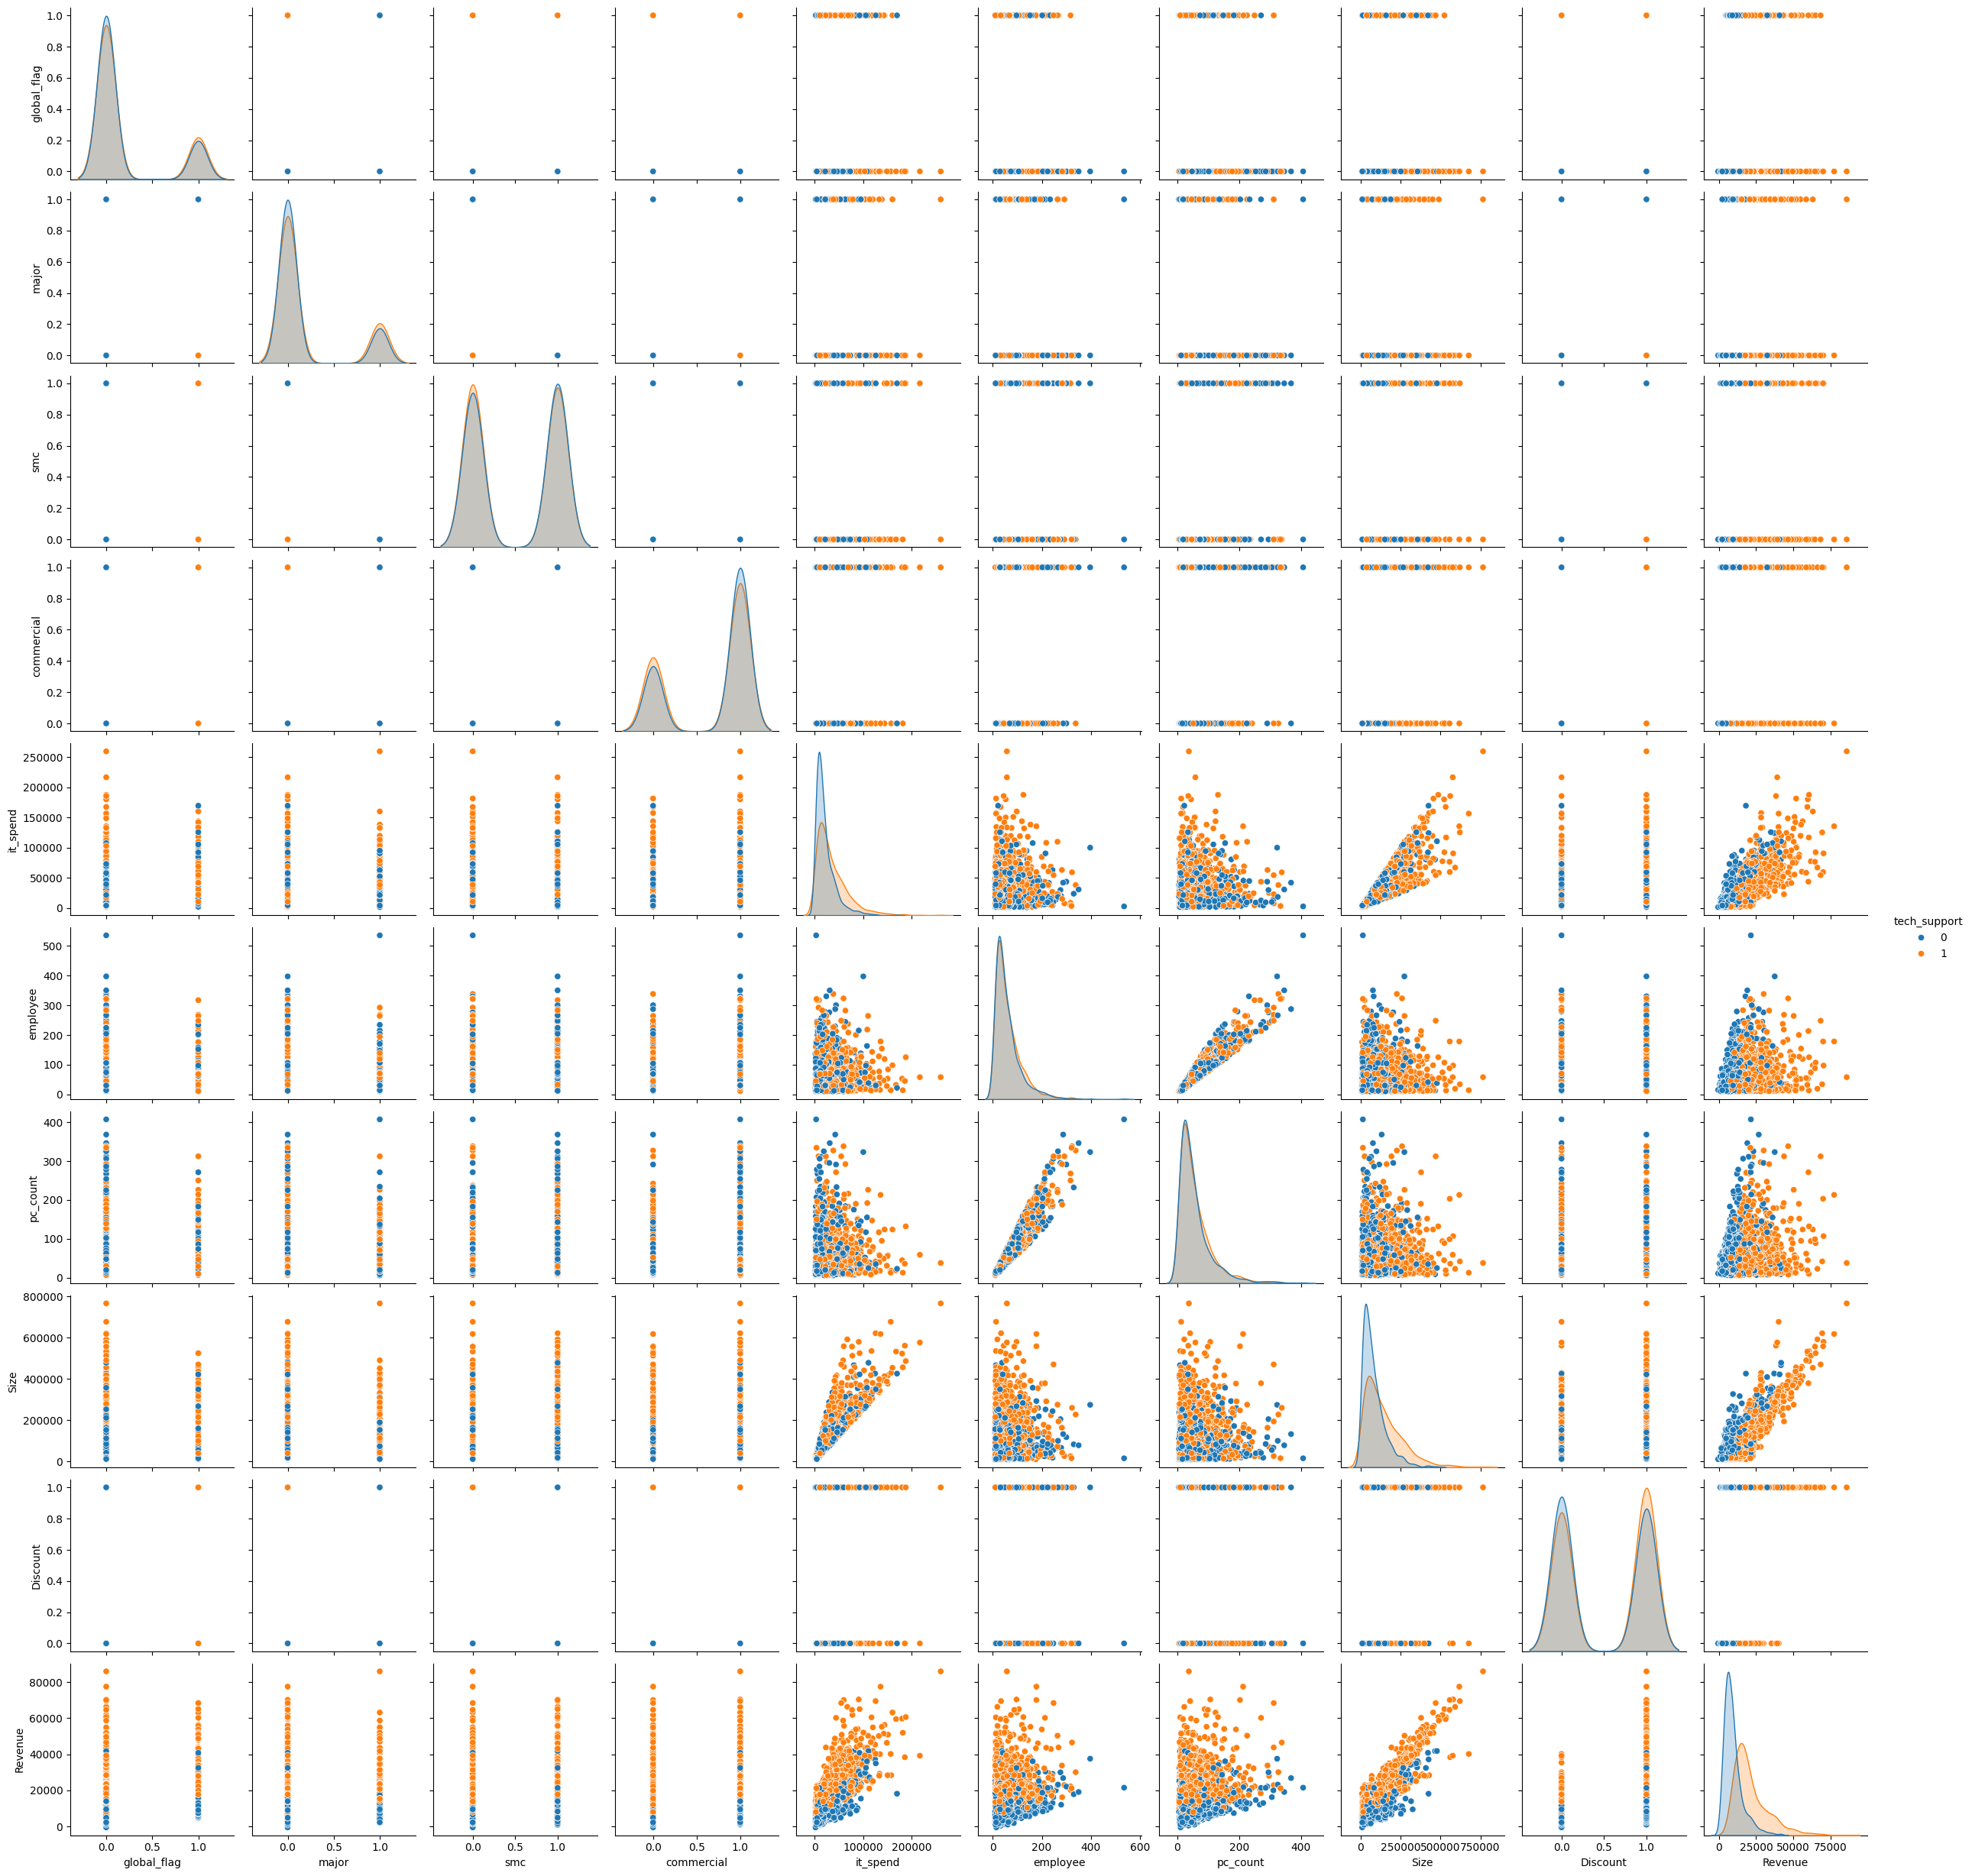

In [134]:
# visualisasi distribusi data
sns.pairplot(data=software_usage, hue='tech_support')

### Metode #1 - Regression

**Regression without control variables**

In [135]:
# Fit linear regression models --> Variabel treatment Discount
# y ~ x
# outcome ~ treatment
model1_disc = sm.ols('Revenue ~ Discount' , data = software_usage)
model1_disc_reg = model1_disc.fit()

# Show the summary of model
model1_disc_reg.summary2().tables[1].applymap(lambda x: f"{x:,.2f}")

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,"10,605.73",328.28,32.31,0.00,"9,961.91","11,249.54"
Discount,"9,387.25",459.46,20.43,0.00,"8,486.17","10,288.33"


In [136]:
# Fit linear regression models --> Variabel treatment Tech Support
# y ~ x
# outcome ~ treatment
model1_tech = sm.ols('Revenue ~ tech_support' , data = software_usage)
model1_tech_reg = model1_tech.fit()

# Show the summary of model
model1_tech_reg.summary2().tables[1].applymap(lambda x: f"{x:,.2f}")

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,"9,302.99",302.25,30.78,0.00,"8,710.23","9,895.75"
tech_support,"12,117.15",426.17,28.43,0.00,"11,281.37","12,952.94"


Hasil perhitungan menggunakan `regresi tanpa kontrol variabel` memberikan hasil yang sama dengan perhitungan pada bagian eksplorasi data, dimana:
- Perusahaan klien yang diberikan `Discount` memiliki spending `$ 9387` lebih besar dibandingkan dengan yang tidak mendapatkan treatment.
- Perusahaan klien yang diberikan `Tech Support` memiliki spending `$ 12117` lebih besar dibandingkan dengan yang tidak mendapatkan treatment.

Selain itu, karena nilai pvalue < alpha (0.05), maka dapat ditarik keseimpulan bahwa variabel treatment berpengaruh signifikan terhadap outcome.

**Regression with control variables**

In [137]:
statistic_obs_disc = software_usage.groupby('Discount').describe().loc[:,(slice(None),['mean','std'])].T

# pisah ribuan dan rounding dua angka di belakang koma
statistic_obs.applymap(lambda x: f"{x:,.2f}")

Discount                   0           1
global_flag  mean       0.20        0.20
             std        0.40        0.40
major        mean       0.21        0.18
             std        0.41        0.39
smc          mean       0.51        0.50
             std        0.50        0.50
commercial   mean       0.69        0.69
             std        0.46        0.46
it_spend     mean  22,915.61   33,409.43
             std   24,072.31   30,817.72
employee     mean      60.29       61.91
             std       53.27       53.64
pc_count     mean      56.11       58.53
             std       51.51       54.13
Size         mean  88,892.64  136,427.37
             std   78,095.11  114,158.66
tech_support mean       0.47        0.53
             std        0.50        0.50
Revenue      mean  10,605.73   19,992.98
             std    6,149.45   13,054.14

In [138]:
statistic_obs_tech = software_usage.groupby('tech_support').describe().loc[:,(slice(None),['mean','std'])].T

# pisah ribuan dan rounding dua angka di belakang koma
statistic_obs_tech.applymap(lambda x: f"{x:,.2f}")

tech_support              0           1
global_flag mean       0.19        0.21
            std        0.39        0.41
major       mean       0.18        0.21
            std        0.38        0.41
smc         mean       0.51        0.50
            std        0.50        0.50
commercial  mean       0.72        0.67
            std        0.45        0.47
it_spend    mean  21,066.49   35,392.95
            std   20,431.96   32,680.07
employee    mean      59.63       62.58
            std       53.95       52.94
pc_count    mean      56.13       58.55
            std       53.09       52.63
Size        mean  83,191.32  142,769.45
            std   71,555.11  116,019.33
Discount    mean       0.48        0.54
            std        0.50        0.50
Revenue     mean   9,302.99   21,420.14
            std    6,375.84   11,847.56

Variabel confounder yang cukup berbeda antar variabel treatment baik discount maupun tech support adalah it_spend dan size, sehingga kedua variable tersebut akan coba dikontrol

In [139]:
# Fit linear regression models (control: it_spend & Size)
# y ~ treatment + confounder + confounder2 + confounder3 ....
model2_disc = sm.ols('Revenue ~ Discount + global_flag + commercial + pc_count', data = software_usage)
model2_disc_reg = model2_disc.fit()

# Show the summary of model
model2_disc_reg.summary2().tables[1].applymap(lambda x: f"{x:,.2f}")

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,"6,556.04",515.54,12.72,0.00,"5,544.99","7,567.09"
Discount,"9,269.83",436.24,21.25,0.00,"8,414.31","10,125.36"
global_flag,"4,702.27",543.02,8.66,0.00,"3,637.32","5,767.21"
commercial,407.46,472.07,0.86,0.39,-518.34,"1,333.27"
pc_count,50.19,4.13,12.16,0.00,42.09,58.29


In [140]:
# Fit linear regression models (control: it_spend & Size)
# y ~ treatment + confounder + confounder2 + confounder3 ....
model2_tech = sm.ols('Revenue ~ tech_support + global_flag + commercial + pc_count', data = software_usage)
model2_tech_reg = model2_tech.fit()

# Show the summary of model
model2_tech_reg.summary2().tables[1].applymap(lambda x: f"{x:,.2f}")

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,"4,983.61",479.21,10.40,0.00,"4,043.81","5,923.41"
tech_support,"11,946.57",403.23,29.63,0.00,"11,155.78","12,737.36"
global_flag,"4,261.87",501.33,8.50,0.00,"3,278.68","5,245.06"
commercial,"1,029.19",436.25,2.36,0.02,173.64,"1,884.73"
pc_count,49.40,3.81,12.97,0.00,41.93,56.88


Hasil perhitungan menggunakan `regresi dengan kontrol variabel` memberikan hasil yang sedikit berbeda dengan `regresi tanpa kontrol variabel` , dimana:
- Perusahaan klien yang diberikan `Discount` tadinya memiliki spending `$ 9387` lebih besar dibandingkan dengan yang tidak mendapatkan treatment sekarang menjadi `$ 9269`
- Perusahaan klien yang diberikan `Tech Support` tadinya memiliki spending `$ 12117` lebih besar dibandingkan dengan yang tidak mendapatkan treatment sekarang menjadi `$ 11155`

Karena nilai pvalue < alpha (0.05), maka dapat ditarik keseimpulan bahwa variabel treatment berpengaruh signifikan terhadap outcome.

### Metode #2 - Distance Matching: k-Neareast Neighbor Matching

Metode kNN akan mengkasifikasi data baru dengan membandingkan karakteristik data baru (data test) dengan data yang ada (data train). 

Dalam konteks proses matching, kNN digunakan untuk mencocokkan observasi-observasi yang serupa berdasarkan karakteristik tertentu (biasanya confounders) antara kelompok treatment dan kelompok kontrol. Tujuannya adalah untuk membuat kelompok yang akan dibandingkan menjadi sebanding atau serupa sehingga perbedaan outcome antara keduanya bisa lebih dipercaya sebagai akibat dari treatment, bukan dari perbedaan dalam karakteristik lainnya.

Kedekatan karakteristik tersebut diukur dengan metrik pengukuran jarak hingga didapatkan k titik data (tetangga) dengan jarak terdekat. Kelas terbanyak yang dimiliki para tetangga ini yang menjadi kelas dari data baru (majority voting).

**Menggunakan library `CausalModel`**

`CausalModel()` parameter:
- `Y`: variabel outcome. Variabel yang ingin diestimasi efek perlakuannya.
- `D`: variabel treatment. Variabel yang menunjukkan apakah suatu observasi menerima perlakuan atau tidak.
- `X`: variabel confounders. Variabel-variabel yang diharapkan mempengaruhi baik outcome maupun treatment.

**Variabel treatment Discount**

In [141]:
# menggunakan .values agar tipe data inputnya berupa tipe data array
Y = software_usage['Revenue'].values
D = software_usage['Discount'].values
X = software_usage[['global_flag','commercial', 'pc_count']].values

In [142]:
from causalinference import CausalModel
model3_disc_distance_knn = CausalModel(Y, D, X)

In [143]:
# **EDA: membandingkan perbedaan kelompok treatment dengan kelompok control**
# EDA: summary_stats
print(model3_disc_distance_knn.summary_stats)


Summary Statistics

                       Controls (N_c=979)        Treated (N_t=1021)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y    10605.726     6149.450    19992.977    13054.140     9387.251

                       Controls (N_c=979)        Treated (N_t=1021)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.202        0.402        0.202        0.402       -0.001
             X1        0.694        0.461        0.689        0.463       -0.011
             X2       56.107       51.505       58.533       54.128        0.046



**Variabel treatment Tech Support**

In [144]:
# menggunakan .values agar tipe data inputnya berupa tipe data array
Y = software_usage['Revenue'].values
D = software_usage['tech_support'].values
X = software_usage[['global_flag','commercial', 'pc_count']].values

In [145]:
from causalinference import CausalModel
model3_tech_distance_knn = CausalModel(Y, D, X)

In [146]:
# **EDA: membandingkan perbedaan kelompok treatment dengan kelompok control**
# EDA: summary_stats
print(model3_tech_distance_knn.summary_stats)


Summary Statistics

                       Controls (N_c=994)        Treated (N_t=1006)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     9302.989     6375.844    21420.142    11847.559    12117.153

                       Controls (N_c=994)        Treated (N_t=1006)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.190        0.393        0.214        0.410        0.059
             X1        0.715        0.452        0.667        0.472       -0.105
             X2       56.126       53.093       58.551       52.630        0.046



In [148]:
# Beberapa parameter pada method `est_via_matching()`
# weights: metrik pengukuran jarak
# matches: jumlah tetangga (k) yang digunakan untuk proses matching

model3_disc_distance_knn.est_via_matching(weights='maha', matches=10)
model3_tech_distance_knn.est_via_matching(weights='maha', matches=10)

# hitung ATE
print(model3_disc_distance_knn.estimates)
print(model3_tech_distance_knn.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   9347.918    456.738     20.467      0.000   8452.713  10243.124
           ATC   9349.118    480.076     19.474      0.000   8408.169  10290.066
           ATT   9346.769    455.362     20.526      0.000   8454.260  10239.277


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE  12067.980    423.895     28.469      0.000  11237.145  12898.815
           ATC  11969.686    437.825     27.339      0.000  11111.548  12827.823
           ATT  12165.102    424.050     28.688      0.000  11333.964  12996.239



Hasil perhitungan menggunakan `K-NN` memberikan hasil yang sama dengan `regresi tanpa kontrol variabel`
- Perusahaan klien yang diberikan `Discount` memiliki spending `$ 9387` lebih besar dibandingkan dengan yang tidak mendapatkan treatment.
- Perusahaan klien yang diberikan `Tech Support` memiliki spending `$ 12117` lebih besar dibandingkan dengan yang tidak mendapatkan treatment.

Karena nilai pvalue < alpha (0.05), maka dapat ditarik keseimpulan bahwa variabel treatment berpengaruh signifikan terhadap outcome.

Dikarenakan matching menggunakan kNN dengan jarak Euclidean membutuhkan nilai bertipe numerik sementara variabel confounder pada kasus ini beberapa bertipe kategorik, maka selanjutnya juga akan dicoba menggunakan metrik distance lain yakni propensity score matching sebagai perbandingan tambahan

### Metode #3 - Propensity Score Matching

- Dikatakan match jika peluang untuk mendapatkan treatment yang mirip

- Propensity scores are typically estimated using logit or probit regression.

Recall Logistic Regression model:

*Logistic Regression merupakan salah satu metode klasifikasi yang konsepnya hampir mirip dengan regresi linear. Hanya saja, dalam logistic regression tidak menghitung secara spesifik nilai prediksi target variable, namun menghitung **kemungkinan/peluang** pada masing-masing kelas target.*

$$
y =  p(x) = Sigmoid(\beta_0 + \beta_1 \cdot x_1 + ... + \beta_n \cdot x_n)
$$

dengan $y$ adalah nilai propensity atau peluang seseorang mendapatkan treatment atau tidak dan $x$ adalah variabel-variabel confounders yang diperhitungkan.

In [173]:
# preprocessing: ubah tipe data
kolom_cat = ['global_flag', 'major', 'smc', 'commercial']
software_usage[kolom_cat] = software_usage[kolom_cat].astype('category')

In [174]:
software_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   global_flag   2000 non-null   category
 1   major         2000 non-null   category
 2   smc           2000 non-null   category
 3   commercial    2000 non-null   category
 4   it_spend      2000 non-null   int64   
 5   employee      2000 non-null   int64   
 6   pc_count      2000 non-null   int64   
 7   Size          2000 non-null   int64   
 8   tech_support  2000 non-null   int64   
 9   Discount      2000 non-null   int64   
 10  Revenue       2000 non-null   float64 
dtypes: category(4), float64(1), int64(6)
memory usage: 117.8 KB


In [175]:
# visualisasi pairplot
# sns.pairplot(data=software_usage, hue='Discount')

In [152]:
# EDA: describe()
#software_usage.describe()

Function: `CausalModel().est_propensity()`

`CausalModel()` parameter:
- `Y`: variabel outcome. Variabel yang ingin diestimasi efek perlakuannya.
- `D`: variabel treatment. Variabel yang menunjukkan apakah suatu observasi menerima perlakuan atau tidak.
- `X`: variabel confounders. Variabel-variabel yang diharapkan mempengaruhi baik outcome maupun treatment.

**Variabel treatment Discount**

In [188]:
# set variable
X = software_usage[['global_flag','commercial', 'pc_count']].values
Y = software_usage['Revenue'].values
D = software_usage['Discount'].values

In [189]:
# model dimana variabel treatmentnya adalah Discount
model4_disc_propensity = CausalModel(Y, D, X)

In [190]:
# Cek summary_stats
print(model4_disc_propensity.summary_stats)


Summary Statistics

                       Controls (N_c=979)        Treated (N_t=1021)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y    10605.726     6149.450    19992.977    13054.140     9387.251

                       Controls (N_c=979)        Treated (N_t=1021)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.202        0.402        0.202        0.402       -0.001
             X1        0.694        0.461        0.689        0.463       -0.011
             X2       56.107       51.505       58.533       54.128        0.046



In [191]:
# Prediksi propensity score
# Estimate the propensity score using logit
model4_disc_propensity.est_propensity()

# model.propensity
print(model4_disc_propensity.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      0.011      0.096      0.112      0.911     -0.177      0.198
            X0     -0.002      0.111     -0.021      0.983     -0.221      0.216
            X1     -0.027      0.097     -0.277      0.782     -0.217      0.163
            X2      0.001      0.001      1.034      0.301     -0.001      0.003



**Variabel treatment Tech Support**

In [192]:
# set variable
X = software_usage[['global_flag','commercial', 'pc_count']].values
Y = software_usage['Revenue'].values
D = software_usage['tech_support'].values

In [193]:
# model dimana variabel treatmentnya adalah Discount
model4_tech_propensity = CausalModel(Y, D, X)

In [194]:
# Cek summary_stats
print(model4_tech_propensity.summary_stats)


Summary Statistics

                       Controls (N_c=994)        Treated (N_t=1006)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     9302.989     6375.844    21420.142    11847.559    12117.153

                       Controls (N_c=994)        Treated (N_t=1006)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.190        0.393        0.214        0.410        0.059
             X1        0.715        0.452        0.667        0.472       -0.105
             X2       56.126       53.093       58.551       52.630        0.046



In [195]:
# Prediksi propensity score
# Estimate the propensity score using logit
model4_tech_propensity.est_propensity()

# model.propensity
print(model4_tech_propensity.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept      0.087      0.096      0.907      0.364     -0.101      0.275
            X0      0.146      0.112      1.309      0.190     -0.073      0.365
            X1     -0.230      0.097     -2.365      0.018     -0.420     -0.039
            X2      0.001      0.001      1.114      0.265     -0.001      0.003



Kita dapat melakukan trimming untuk meningkatkan keseimbangan (balance) antara grup kontrol dan grup treatment dengan menghilangkan observasi yang memiliki propensity score yang terlalu ekstrem (baik terlalu rendah maupun terlalu tinggi) sehingga sulit untuk dicocokkan dengan baik.

In [196]:
# trimming
# additional step, tergantung persebaran propensity scorenya ada yg ekstrim atau enggak
# model4_disc_propensity.trim_s()
# model4_tech_propensity.trim_s()

# cek summary_stats
# print(model4_disc_propensity.summary_stats)
# print(model4_tech_propensity.summary_stats)

**Matching dengan propensity score**

In [213]:
# estimasi dengan matching
model4_disc_propensity.est_via_matching()
model4_tech_propensity.est_via_matching()

# estimasi ATE
print(model4_disc_propensity.estimates)
print(model4_tech_propensity.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   9333.004    585.177     15.949      0.000   8186.057  10479.950
           ATC   9505.756    651.907     14.581      0.000   8228.019  10783.493
           ATT   9167.358    617.383     14.849      0.000   7957.287  10377.428


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE  12081.613    528.126     22.876      0.000  11046.487  13116.740
           ATC  12157.207    579.756     20.970      0.000  11020.885  13293.530
           ATT  12006.920    547.764     21.920      0.000  10933.304  13080.537



Hasil perhitungan menggunakan `Propensity Score` memberikan hasil yang sedikit berbeda dengan `regresi tanpa kontrol variabel`
- Perusahaan klien yang diberikan `Discount` memiliki spending `$ 9333` lebih besar dibandingkan dengan yang tidak mendapatkan treatment.
- Perusahaan klien yang diberikan `Tech Support` memiliki spending `$ 12081` lebih besar dibandingkan dengan yang tidak mendapatkan treatment.

Karena nilai pvalue < alpha (0.05), maka dapat ditarik keseimpulan bahwa variabel treatment berpengaruh signifikan terhadap outcome.

### Summary: Perbandingan ETA pada beberapa metode perhitungan

In [224]:
data = [
    ('manual_calculation', 9387.25, 12117.15),
    ('regression_without_control', 9387.25, 12117.15),
    ('regression_with_control', 9269.83, 11946.57),
    ('distant_matching_knn', 9347.918, 12067.980),
    ('matching_propensity', 9333.004, 12081.613)
]

df = pd.DataFrame(data, columns=['metode', 'treat_discount', 'treat_tech_support'])
df

,metode,treat_discount,treat_tech_support
0,manual_calculation,9387.250,12117.150
1,regression_without_control,9387.250,12117.150
2,regression_with_control,9269.830,11946.570
3,distant_matching_knn,9347.918,12067.980
4,matching_propensity,9333.004,12081.613


Kesimpulan:

- Perbedaan diantara metode yang digunakan tidak terlalu besar
- Penambahan revenue perusahaan ketika klien diberikan treatmnet `tech support` lebih tinggi dibandingkan treatment `discount`. Hal ini mungkin disebabkan karena jika hanya diberi discount, klien yang sudah memiliki kepastian mau membeli barang/jasa tertentu teteap akan menambah pembeliannya namun tidak terlalu besar karena belum punya tambahan pengetahuan (product knowledge) mengenai baru apa lagi yang sesuai dengan kebutuhannya saat ini.
- Sementara jika diberikan treatment tech support, seiring dengan diskusi saat support diberikan, `klien mendapatkan semacam konsultasi/ masukan mengenai barang-barang apa lagi yang bisa ditambahkan untuk dipakai oleh perusahaan klien tersebut` yang mana mungkin klien belum punya bayangan sebelumnya akan adanya kebutuhan tersebut.